# Training a timm model

In [1]:
from IPython.display import clear_output
!pip install timm
!pip install fastai
!pip install wandb
clear_output()

In [2]:
# Try to mount Google Drive
try:
    from google.colab import drive
    drive.mount('/content/drive')
except ImportError:
    print("This code is not running in Google Colab.")

Mounted at /content/drive


In [1]:
import os
# Ensure fallback is enabled
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'

In [98]:
# Imports
from typing import Optional, List

import torch
import torch.nn as nn
import torch.nn.functional as F

from timm import create_model

from fastai.callback.tracker import SaveModelCallback, EarlyStoppingCallback
from fastai.vision.all import *
from fastai.callback.wandb import *
from fastai.metrics import Dice
from fastai import *

import cv2
from scipy.ndimage import gaussian_filter
import wandb

# Defineing the U-net

In [3]:
class Conv2dBnAct(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, padding=0,
                 stride=1, act_layer=nn.ReLU, norm_layer=nn.BatchNorm2d):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=padding, bias=False)
        self.bn = norm_layer(out_channels)
        self.act = act_layer(inplace=True)
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.act(x)
        return x

In [4]:
class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, scale_factor=2.0, act_layer=nn.ReLU, norm_layer=nn.BatchNorm2d):
        super().__init__()
        conv_args = dict(kernel_size=3, padding=1, act_layer=act_layer)
        self.scale_factor = scale_factor
        if norm_layer is None:
            self.conv1 = Conv2dBnAct(in_channels, out_channels, **conv_args)
            self.conv2 = Conv2dBnAct(out_channels, out_channels,  **conv_args)
        else:
            self.conv1 = Conv2dBnAct(in_channels, out_channels, norm_layer=norm_layer, **conv_args)
            self.conv2 = Conv2dBnAct(out_channels, out_channels, norm_layer=norm_layer, **conv_args)

    def forward(self, x, skip: Optional[torch.Tensor] = None):
        if self.scale_factor != 1.0:
            x = F.interpolate(x, scale_factor=self.scale_factor, mode='nearest')
        if skip is not None:
            x = torch.cat([x, skip], dim=1)
        x = self.conv1(x)
        x = self.conv2(x)
        return x

In [5]:
class UnetDecoder(nn.Module):

    def __init__(
            self,
            encoder_channels,
            decoder_channels=(256, 128, 64, 32, 16),
            final_channels=1,
            norm_layer=nn.BatchNorm2d,
            center=False,
    ):
        super().__init__()

        if center:
            channels = encoder_channels[0]
            self.center = DecoderBlock(channels, channels, scale_factor=1.0, norm_layer=norm_layer)
        else:
            self.center = nn.Identity()

        in_channels = [in_chs + skip_chs for in_chs, skip_chs in zip(
            [encoder_channels[0]] + list(decoder_channels[:-1]),
            list(encoder_channels[1:]) + [0])]
        out_channels = decoder_channels

        self.blocks = nn.ModuleList()
        for in_chs, out_chs in zip(in_channels, out_channels):
            self.blocks.append(DecoderBlock(in_chs, out_chs, norm_layer=norm_layer))
        self.final_conv = nn.Conv2d(out_channels[-1], final_channels, kernel_size=(1, 1))

        self._init_weight()

    def _init_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                torch.nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def forward(self, x: List[torch.Tensor]):
        encoder_head = x[0]
        skips = x[1:]
        x = self.center(encoder_head)
        for i, b in enumerate(self.blocks):
            skip = skips[i] if i < len(skips) else None
            x = b(x, skip)
        x = self.final_conv(x)
        return x

In [6]:
class Unet(nn.Module):
    """Unet is a fully convolution neural network for image semantic segmentation
    Args:
        encoder_name: name of classification model (without last dense layers) used as feature
            extractor to build segmentation model.
        encoder_weights: one of ``None`` (random initialization), ``imagenet`` (pre-training on ImageNet).
        decoder_channels: list of numbers of ``Conv2D`` layer filters in decoder blocks
        decoder_use_batchnorm: if ``True``, ``BatchNormalisation`` layer between ``Conv2D`` and ``Activation`` layers
            is used.
        num_classes: a number of classes for output (output shape - ``(batch, classes, h, w)``).
        center: if ``True`` add ``Conv2dReLU`` block on encoder head
    NOTE: This is based off an old version of Unet in https://github.com/qubvel/segmentation_models.pytorch
    """

    def __init__(
            self,
            backbone='resnet50',
            backbone_kwargs=None,
            backbone_indices=None,
            decoder_use_batchnorm=True,
            decoder_channels=(256, 128, 64, 32, 16),
            in_chans=1,
            num_classes=5,
            center=False,
            norm_layer=nn.BatchNorm2d,
    ):
        super().__init__()
        backbone_kwargs = backbone_kwargs or {}
        # NOTE some models need different backbone indices specified based on the alignment of features
        # and some models won't have a full enough range of feature strides to work properly.
        encoder = create_model(
            backbone, features_only=True, out_indices=backbone_indices, in_chans=in_chans,
            pretrained=True, **backbone_kwargs)
        encoder_channels = encoder.feature_info.channels()[::-1]
        self.encoder = encoder

        if not decoder_use_batchnorm:
            norm_layer = None
        self.decoder = UnetDecoder(
            encoder_channels=encoder_channels,
            decoder_channels=decoder_channels,
            final_channels=num_classes,
            norm_layer=norm_layer,
            center=center,
        )

    def forward(self, x: torch.Tensor):
        x = self.encoder(x)
        x.reverse()  # torchscript doesn't work with [::-1]
        x = self.decoder(x)
        return x

# Defineing helper functions

In [8]:
data_path_train = Path('data/')

def get_data(size, tfms=None, bs=64):
    if not tfms:
        tfms = [IntToFloatTensor(div_mask=255),
                 FlipItem(p=0.5),
                 Rotate(max_deg=180, p=0.5),
                 Zoom(max_zoom=1.2, min_zoom=0.5, p=0.5, pad_mode='reflection')]
    db = DataBlock(blocks=(ImageBlock(),MaskBlock()),
                   splitter=RandomSplitter(valid_pct=0.1,seed=2021),
                   batch_tfms=tfms,
                   item_tfms=[Resize(size)],
                   get_items=get_image_files, get_y=lambda o:str(o).replace('images','labels'))
    return db.dataloaders(source=data_path_train/'train'/'images',bs=bs)

In [8]:
data_path_test = Path('data_old/')

def get_test_data(size, bs=64):
    db = DataBlock(blocks=(ImageBlock(), MaskBlock()),
                   get_items=get_image_files, 
                   get_y=lambda o: str(o).replace('images', 'labels'),
                   item_tfms=[Resize(size)])
                   
    return db.dataloaders(source=data_path_test/'test'/'images', bs=bs)

In [9]:
class CombinedLoss:
    "Dice and Focal combined"
    def __init__(self, axis=1, smooth=1e-06, alpha=1., reduction='mean'):
        store_attr()
        self.focal_loss = FocalLossFlat(axis=axis)
        self.dice_loss =  DiceLoss(axis, smooth, reduction)

    def __call__(self, pred, targ):
        return self.focal_loss(pred, targ) + self.alpha * self.dice_loss(pred, targ)

    def decodes(self, x):    return x.argmax(dim=self.axis)
    def activation(self, x): return F.softmax(x, dim=self.axis)

In [10]:
wandb_callback = WandbCallback(
    log='all',
    log_preds=False,
    log_preds_every_epoch=False,
    log_model=False,
    model_name=None,
    log_dataset=False,
    dataset_name=None,
    valid_dl=None,
    n_preds=36,
    seed=12345,
    reorder=True
)

# Training

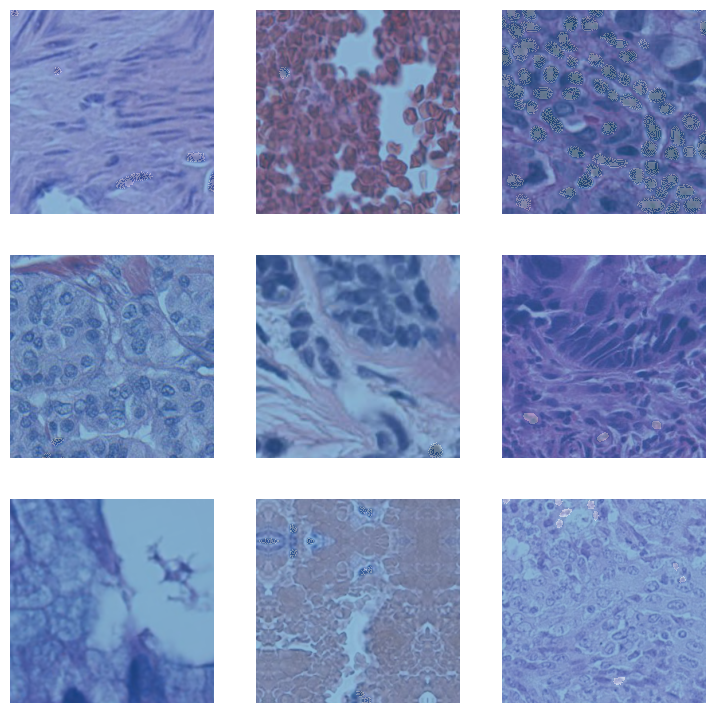

In [20]:
dls = get_data(size=256,bs=32)
dls.show_batch(max_n=9)

In [11]:
metrics = Dice()
loss_func = CombinedLoss()

In [28]:
# Learner with combined loss and Dice metric
learn = Learner(dls, Unet(backbone='resnet50.a1_in1k', decoder_use_batchnorm=True, in_chans=3, num_classes=2),
                loss_func=CombinedLoss(),
                metrics=[metrics], cbs=[SaveModelCallback(monitor='dice', fname='best_model', comp=np.greater),
                EarlyStoppingCallback(monitor='dice', min_delta=0.01, patience=5)])

SuggestedLRs(valley=0.001737800776027143)

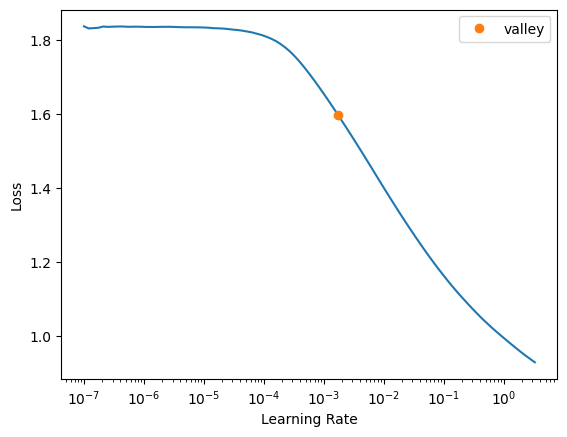

In [15]:
learn.lr_find()

In [ ]:
# Freeze the pretrained backbone
learn.freeze()
# Train the head of the network for a few epochs
# Use the higher end of the learning rate suggested by lr_find
learn.fit_one_cycle(4, lr_max=1e-4)
# Unfreeze the entire model
learn.unfreeze()
# Continue training with differential learning rates
# The learning rate for the earlier layers should be lower
learn.fit_one_cycle(15, lr_max=slice(1e-3, 1e-2))

# Connnected components analysis

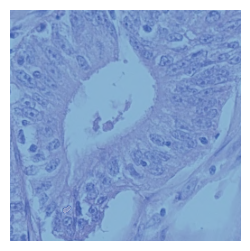

In [14]:
# Load the test data
test_dls = get_test_data(size=256, bs=1)
test_dls.show_batch(max_n=4)

In [15]:
model_path = 'best_model_resnet50_48'

# Learner with combined loss and Dice metric
learn_test = Learner(test_dls, Unet(backbone='resnet50.a1_in1k', decoder_use_batchnorm=True, in_chans=3, num_classes=2),
                loss_func=CombinedLoss(),
                metrics=[metrics])

In [16]:
learn_test.load(model_path)

/Users/marcusnsr/miniconda3/envs/bachelor/lib/python3.8/site-packages/fastai/learner.py:59: UserWarning: Saved file doesn't contain an optimizer state.
  elif with_opt: warn("Saved file doesn't contain an optimizer state.")


In [14]:
# Define save paths for predictions and targets
save_preds_path = Path('data/test_results/predictions.pt')
save_targs_path = Path('data/test_results/targets.pt')

# Ensure the directories exist or create them
save_preds_path.parent.mkdir(parents=True, exist_ok=True)
save_targs_path.parent.mkdir(parents=True, exist_ok=True)

# Get predictions and targets from the test set
preds, targs = learn_test.get_preds(dl=test_dls, reorder=True,)

# Manually save the predictions and targets
torch.save(preds, save_preds_path)
torch.save(targs, save_targs_path)

# Check if the files have been saved successfully
if save_preds_path.is_file() and save_targs_path.is_file():
    print(f"Predictions saved to: {save_preds_path}")
    print(f"Targets saved to: {save_targs_path}")
else:
    print("Files were not saved successfully.")

Predictions saved to: data/test_results/predictions.pt
Targets saved to: data/test_results/targets.pt


In [15]:
preds = torch.load(save_preds_path)
targs = torch.load(save_targs_path)

In [23]:
# Threshold predictions to get binary segmentation maps
# Adjust the threshold value as necessary
threshold = 0.5
binary_preds = (preds > threshold).int()

In [24]:
from skimage.measure import label, regionprops

def count_cells(segmented_img):
    # Label distinct regions
    labeled_img = label(segmented_img)
    # Count regions with area larger than a threshold, if necessary, to avoid counting noise
    regions = regionprops(labeled_img)
    return len(regions)

# Assuming your images are single-channel and the first dimension is the batch dimension
# You might need to adjust indexing depending on your data's shape
pred_counts = [count_cells(binary_pred.squeeze()) for binary_pred in binary_preds]
target_counts = [count_cells(target.squeeze()) for target in targs]

In [26]:
# Calculate the absolute difference in cell count between predictions and ground truth
differences = [abs(p - t) for p, t in zip(pred_counts, target_counts)]

# Determine if the difference is typically more or fewer cells
positive_differences = [diff for diff in differences if diff > 0]
negative_differences = [diff for diff in differences if diff < 0]

# Calculate the proportion of positive and negative differences
prop_more_cells = len(positive_differences) / len(differences)
prop_fewer_cells = len(negative_differences) / len(differences)

# Print the results
print(f"Proportion of images with more predicted cells: {prop_more_cells:.2f}")
print(f"Proportion of images with fewer predicted cells: {prop_fewer_cells:.2f}")

# Analyze the distribution of differences
mean_difference = np.mean(differences)
median_difference = np.median(differences)
max_difference = np.max(differences)
min_difference = np.min(differences)
std_difference = np.std(differences)

print(f"Mean absolute difference in cell count: {mean_difference:.2f}")
print(f"Median absolute difference in cell count: {median_difference:.2f}")
print(f"Maximum absolute difference in cell count: {max_difference}")
print(f"Minimum absolute difference in cell count: {min_difference}")
print(f"Standard deviation of absolute difference in cell count: {std_difference:.2f}")

Proportion of images with more predicted cells: 0.57
Proportion of images with fewer predicted cells: 0.00
Mean absolute difference in cell count: 2.88
Median absolute difference in cell count: 1.00
Maximum absolute difference in cell count: 26
Minimum absolute difference in cell count: 0
Standard deviation of absolute difference in cell count: 4.60


In [27]:
# Count the number of positive and negative differences
num_more_cells = len(positive_differences)
num_fewer_cells = len(negative_differences)

# Print the counts
print(f"Number of images with more predicted cells: {num_more_cells}")
print(f"Number of images with fewer predicted cells: {num_fewer_cells}")

# Determine if the model predicts more or fewer cells overall
if num_more_cells > num_fewer_cells:
    print("The model tends to predict more cells than the ground truth.")
elif num_more_cells < num_fewer_cells:
    print("The model tends to predict fewer cells than the ground truth.")
else:
    print("The model predicts an equal number of cells compared to the ground truth.")


Number of images with more predicted cells: 113
Number of images with fewer predicted cells: 0
The model tends to predict more cells than the ground truth.


In [29]:
# Compute the average number of cells across all images in the dataset
average_cell_count = np.mean([count_cells(target.squeeze()) for target in targs])
print(f"Average cell count across all images: {average_cell_count:.2f}")

Average cell count across all images: 3.88


- 1. Proportion of images with more predicted cells: Around $54 \%$ of the images have more cells predicted by the model compared to the ground truth, indicating a tendency to overestimate.
- 2. Proportion of images with fewer predicted cells: No images have fewer predicted cells, showing a consistent bias towards overestimation.
- 3. Mean absolute difference in cell count: On average, the model's predicted cell count differs from the ground truth by approximately 2.69 cells.
- 4. Median absolute difference in cell count: Half of the images have a difference of 1 cell or fewer between predicted and ground truth counts.
- 5. Maximum absolute difference in cell count: The largest discrepancy observed between predicted and ground truth counts is 26 cells.
- 6. Minimum absolute difference in cell count: Some images exhibit perfect agreement between predicted and ground truth counts ( 0 cells difference).
- 7. Standard deviation of absolute difference in cell count: The variability in absolute differences from the mean is approximately 4.59 cells.
- 8. Average cell count across all images are 3.69

In [30]:
# Give an accuracy score based on the proportion of images with the correct number of cells
num_correct = len([diff for diff in differences if diff == 0])
accuracy = num_correct / len(differences)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.43


# Generate heatmap

In [93]:
def generate_probability_heatmaps(learner, dl, class_idx=1):
    learner.model.eval()  # Ensure the model is in evaluation mode
    preds, _ = learner.get_preds(dl=dl, with_decoded=False)  # Get raw predictions
    
    # Extract the probability heatmaps for the specified class
    heatmaps = preds[:, class_idx, :, :].cpu().numpy()
    # Apply gaussian smoothing to the heatmaps
    heatmaps = gaussian_filter(heatmaps, sigma=2)

    # Return heatmaps and the original images
    return heatmaps

heatmaps = generate_probability_heatmaps(learn_test, test_dls, class_idx=1)

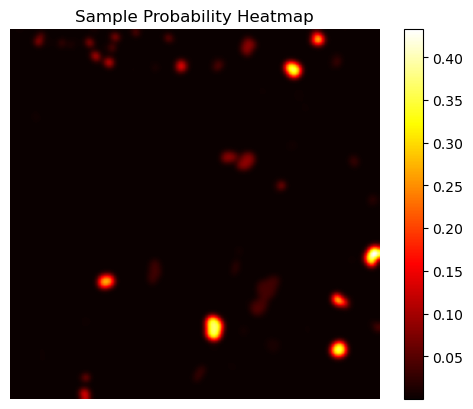

In [94]:
# Plot a sample heatmap
plt.imshow(heatmaps[0], cmap='hot')
plt.axis('off')
plt.colorbar()
plt.title('Sample Probability Heatmap')
plt.show()

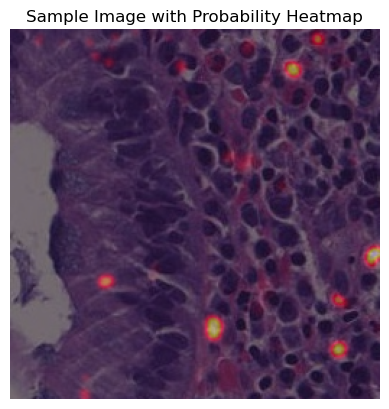

In [152]:
# Plot a sample heatmap on top of the original image
sample_idx = 0
sample_img = test_dls.items[sample_idx]
sample_img = PILImage.create(sample_img)
sample_img = sample_img.resize((256, 256))
sample_img = np.array(sample_img)

# Normalize the heatmap
heatmap = heatmaps[sample_idx]
heatmap = (heatmap - np.min(heatmap)) / (np.max(heatmap) - np.min(heatmap))
heatmap = np.uint8(255 * heatmap)

# Plot the heatmap on top of the original image
save_path = Path('sample_heatmap.png')
plt.imshow(sample_img, cmap='gray')
plt.imshow(heatmap, cmap='hot', alpha=0.5)
plt.axis('off')
plt.title('Sample Image with Probability Heatmap')
plt.savefig(save_path)
plt.show()